In [1]:
__author__ = "Francesca Vera and Robert Fernandez"
__version__ = "CS224u, Stanford, Spring 2019"

In [2]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
#The majority of code is based on this tutorial as a primer into using PyTorch and it's RNN to preprocess, train,
#and evalutate data

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

#this is a preprocessing block of code. Grabs all names and keep names in caregroies. Converts all unicode to ascii,
#perserves the category, and stores it in category_lines. category_lines is a double array of categories to lines

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [16]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))

#demo showing first a conversion of a letter to a tensor, where the output dim is all ascii characters plus " .,;'"

#second is a deom showing one-hot encoding. Line to tensor generates a 3 dim representing line length, 1, and the
#letter length. Each Letter gets a 1-hot array and is chained together

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories) #rnn base created here

#here's an example of defining an RNN based off torch nn modules. This version is a base RNN class and not an LSTM

#After searching, it seems like RNN and LSTM are built into pytorch. We will most likely want to use LSTM based on
#our studies. Gonna try an example:

In [17]:
lstm = nn.LSTM(3, 3)
#nice. Ok, here's an LSTM example. Documentation is in modules.nn on pytorch, link:
#https://pytorch.org/docs/stable/nn.html , then search for LSTM

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

#example of prediction output

tensor([[-2.9143, -2.8531, -2.9223, -2.8982, -2.8782, -2.8364, -2.9175, -2.9579,
         -2.8601, -2.9149, -2.8950, -2.8652, -2.9368, -2.8223, -2.8346, -2.9574,
         -2.9368, -2.8419]], grad_fn=<LogSoftmaxBackward>)


In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

#category derived from output and index

('Portuguese', 13)


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    
#random training example fetcher

category = Portuguese / line = Vargas
category = French / line = Gage
category = Italian / line = Cuocco
category = Portuguese / line = Costa
category = Dutch / line = Buren
category = Irish / line = Casey
category = German / line = Geissler
category = Czech / line = Finferovy
category = Polish / line = Gorecki
category = English / line = Mcgowan


In [10]:
criterion = nn.NLLLoss()
#loss function setup

In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() #passovers, rnn was established beforehand

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

#train function

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess on print call
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses on plot request
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

#trains an RNN model!

5000 5% (0m 11s) 2.5485 Salazar / German ✗ (Portuguese)
10000 10% (0m 25s) 1.8149 Jong / Chinese ✗ (Korean)
15000 15% (0m 39s) 2.6806 Laycock / Czech ✗ (English)
20000 20% (0m 54s) 1.3831 Aswad / Arabic ✓
25000 25% (1m 7s) 2.9374 Powis / Greek ✗ (English)
30000 30% (1m 24s) 2.1906 Alphen / English ✗ (Dutch)
35000 35% (1m 36s) 1.2255 Naomhan / Irish ✓
40000 40% (1m 44s) 1.3728 Plisko / Russian ✗ (Czech)
45000 45% (1m 53s) 1.5808 Blazek / Polish ✗ (Czech)
50000 50% (2m 1s) 0.0284 Takishida / Japanese ✓
55000 55% (2m 9s) 2.9419 Han / Chinese ✗ (Korean)
60000 60% (2m 18s) 0.2369 Carboni / Italian ✓
65000 65% (2m 27s) 2.6289 Fertig / Scottish ✗ (German)
70000 70% (2m 36s) 1.9594 Abamelek / Czech ✗ (Russian)
75000 75% (2m 44s) 4.8320 Pitomets / Dutch ✗ (Russian)
80000 80% (2m 53s) 0.3765 Ciardha / Irish ✓
85000 85% (3m 1s) 0.7097 Veprentsev / Russian ✓
90000 90% (3m 9s) 0.1916 Ziemniak / Polish ✓
95000 95% (3m 18s) 1.6449 Rompu / Dutch ✓
100000 100% (3m 26s) 0.3486 Dam / Vietnamese ✓


In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

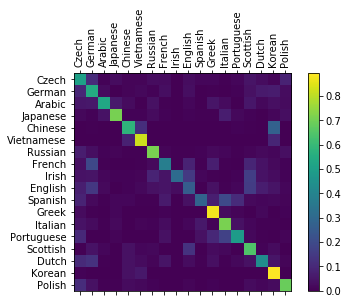

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.82) Czech
(-1.11) Russian
(-1.70) Polish

> Jackson
(-0.15) Scottish
(-2.65) English
(-3.70) Russian

> Satoshi
(-0.77) Japanese
(-1.84) Polish
(-2.29) Scottish
